# Tutorial 1 - RNN Sequence classifier

In this notebook, we will predict the winner of a basketball game based on the scores observed in the first 3 quarters of the game. Each column represents the beginning of a minute during the game. (There are 12 minutes in each quarter. There are  3 quarters in the data, so we have 36 columns as input variables in chronological order.) The values captured in each column represent the score difference observed at that minute (home score minus away score)<br><br>

The last column `W` represents whether the home team (1) or the away team (0) won the game. This is the target variable. <br><br>
**Our unit of analysis is a single game.**

In [1]:
# Common imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)
tf.random.set_seed(1)

## Load and split data

Basketball data consists of each row (observation) representing a single game. The first 36 columns represent the score difference at each minute of the game. The last column represents the winner of the game (1 = home team, 0 = away team). The data is stored in a csv file. We will load the data into a pandas dataframe.

In [2]:
data = pd.read_csv("basketball.csv")

We see that we have 1230 observations (games) and 37 columns (36 minutes of the game + 1 target variable).  

In [3]:
data.shape

(1230, 37)

Split each observation into a sequence of 36 observations (minutes) and a single observation (winner). The sequence of 36 observations will be the input (X) to the RNN. The single observation (y) will be the target variable.

In [4]:
y = data['W']
X = data.drop('W', axis=1)

In [5]:
y = np.array(y).astype(np.int8) 
X = np.array(X).astype(np.float32)

Finally, we need to split the data into training and test sets. A random split on this data is OK, as each 'game' (observation) is independent of the others. We will use 70% of the data for training and 30% for testing.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Create dataframe to store results    

We are running 8 models in this notebook. We will store the results in a dataframe for easy comparison.

In [7]:
df_results = pd.DataFrame({'model': [], 'time': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []})

# A normal (cross-sectional) NN

This model assumes that the data is NOT a time-series data set. It treats the data as cross-sectional and the columns being independent of each other.

In [8]:
print(X_train.shape)  # 2d array of shape (n_samples, n_features)
print(y_train.shape)  # 1d array of shape (n_samples,)

(861, 36)
(861,)


In [9]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[36, 1]),
    keras.layers.Dense(72, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  
])

In [10]:
model.compile(
    loss="binary_crossentropy",  # If multiclass, use "sparse_categorical_crossentropy" as the loss function
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 36)                0         
                                                                 
 dense (Dense)               (None, 72)                2664      
                                                                 
 dense_1 (Dense)             (None, 1)                 73        
                                                                 
Total params: 2,737
Trainable params: 2,737
Non-trainable params: 0
_________________________________________________________________


In [11]:
### How to interpret the output shape?

* The first layer
  * None is a wild-card representing the number of observations - this will be the number of observations in a batch that is fed into the network.
  * 36 is the number of units in the layer, since there will be 36 outputs from this layer 36, the second dimension will have 36
* The second layer
  * None is a wild-card representing the number of observations - this will be the number of observations in a batch that is fed into the network. This will be the same at each later, since the batch size is the same during each epoch.
  * 72 is the number of units in the layer, since there will be 72 outputs from these 72 units
* The third layer
  * None is a wild-card, is the number of observations given in the batch.
  * 1 is the number of units in the layer. Since the output is a binary value, there is one unit for the output, and therefore 1 is the number of outputs.


We can write this formulaically as:

In [11]:
p = 1  # for NN, one weight per unit input
b = 1  # for NN, one bias per unit

# First hidden layer
i = 36 # 36 inputs from the previous layer (flatten layer)
h = 72 # number of units in this layer 

p * (h*i + b*h)

2664

### Calculate the number of paramaters for the model

* The first later doesn't have any parameters, because it's just flattening the input
    * 0 inputs to 36 unites, is 0 weights and zero biases
* The second layer has 36 units connecting to 72 units, so 36**72 weights. If each weight also has a bias, then we add 72
    * 36*72+72 = 2664
* The third layer has 72 outputs from the previous later to 1 unit, so 72 weights. If each unit in the layer has a bias, then we add 1 since there is only one unit
    * 72+1=73

https://towardsdatascience.com/counting-no-of-parameters-in-deep-learning-models-by-hand-8f1716241889

In [12]:
import time
start_time = time.time()

call_back = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_train, 
    y_train, 
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[call_back]
)

end_time = time.time()

Epoch 1/50
27/27 [==============================] - 2s 20ms/step - loss: 0.9128 - accuracy: 0.6841 - val_loss: 0.5951 - val_accuracy: 0.7696
Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: 0.5719 - accuracy: 0.7387 - val_loss: 0.5466 - val_accuracy: 0.7615
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 0.5106 - accuracy: 0.7573 - val_loss: 0.4871 - val_accuracy: 0.7805
Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: 0.4628 - accuracy: 0.7793 - val_loss: 0.4700 - val_accuracy: 0.7859
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 0.4434 - accuracy: 0.7979 - val_loss: 0.4607 - val_accuracy: 0.7967
Epoch 6/50
27/27 [==============================] - 0s 5ms/step - loss: 0.4154 - accuracy: 0.7921 - val_loss: 0.4516 - val_accuracy: 0.7995
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: 0.4091 - accuracy: 0.8060 - val_loss: 0.4661 - val_accuracy: 0.7967
Epoch 8/50
27/27 [=

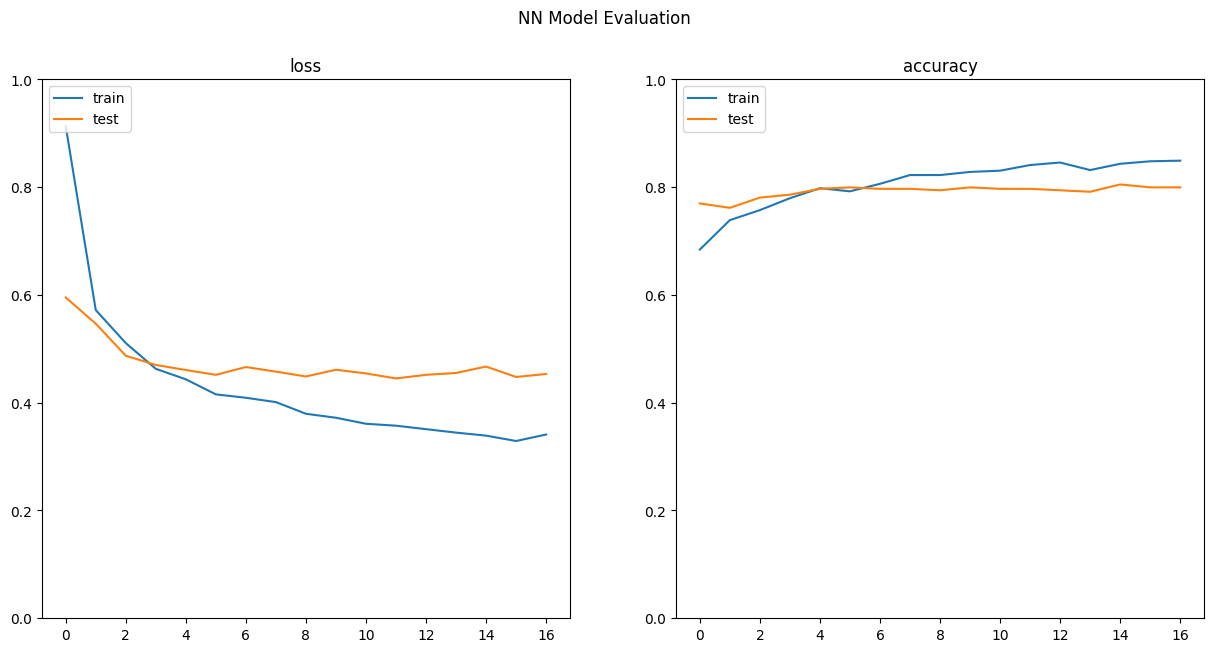

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('NN Model Evaluation')

ax1.set_title('loss')
ax1.set_ylim(0, 1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('accuracy')
ax2.set_ylim(0, 1)
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

In [14]:
y_pred = model.predict(X_test)
y_pred[:10]

12/12 [==============================] - 0s 2ms/step


array([[0.9016681 ],
       [0.9945599 ],
       [0.04267224],
       [0.0255304 ],
       [0.65555954],
       [0.25756532],
       [0.9168224 ],
       [0.6680493 ],
       [0.14144987],
       [0.9168985 ]], dtype=float32)

In [15]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function
y_pred = (y_pred > 0.5).astype('int8') # let's turn these into predictions (0 or 1)

print(classification_report(y_test, y_pred, digits=4))

12/12 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0     0.8026    0.7305    0.7649       167
           1     0.7926    0.8515    0.8210       202

    accuracy                         0.7967       369
   macro avg     0.7976    0.7910    0.7929       369
weighted avg     0.7972    0.7967    0.7956       369



Store the results into the results dataframe.

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['NN'], 
        'time': [end_time - start_time],
        'accuracy': [accuracy_score(y_test, y_pred)], 
        'precision': [precision_score(y_test, y_pred)], 
        'recall': [recall_score(y_test, y_pred)], 
        'f1': [f1_score(y_test, y_pred)]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

## Transform data for RNN

RNN requires input of three dimensions:
* The first dimension is the number of observations (games). 
* The second dimension is the number of time steps (minutes). 
* The third dimension is the number of features (1). 
  
Our input variable (X) is a sequence of 36 observations. We will use the `reshape` method to reshape the data into a 3D array. The `reshape` method will return a 3D array with the shape (861, 36, 1) for the training data and (369, 36, 1) for the test data.

In [17]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)

(861, 36, 1)
(369, 36, 1)


# Simple RNN with one layer

In [18]:
n_steps = 36
n_inputs = 1

model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(40, input_shape=[n_steps, n_inputs]),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 40)                1680      
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
Total params: 1,721
Trainable params: 1,721
Non-trainable params: 0
_________________________________________________________________


### How to interpret the output shape.

* First layer:
  * None is a wild-card representing the number of observations - this will be the number of observations in a batch that is fed into the network.
  * There are 32 RNN units and each produces one output. Therefore, 32 is the output shape.
* In the second layer, there is one unit and it produces one output. Therefore, 1 * 1 = 1

### Calculate the number of paramaters for the model

In [19]:
p = 1 # number of parameters per unit (for RNN one remember gate)
b = 1 # number of biases per unit, for RNN this is 1 (for GRU this is 3, and LSTM this is 4)

##################################
# For first layer....

h = 40 # number of units in the layer
i = 1  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# for the last layer

# This is simply 40 outputs coming from the previous later plus 1 bias term
print("Last layer params = ", 40+1)

First layer params =  1680
Last layer params =  41


In [20]:
from tensorflow.keras.callbacks import EarlyStopping

# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=['accuracy']
)

In [21]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0, patience=5, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=50,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/50
27/27 [==============================] - 3s 31ms/step - loss: 0.4605 - accuracy: 0.7933 - val_loss: 0.4142 - val_accuracy: 0.8238
Epoch 2/50
27/27 [==============================] - 0s 11ms/step - loss: 0.4269 - accuracy: 0.8002 - val_loss: 0.4138 - val_accuracy: 0.8076
Epoch 3/50
27/27 [==============================] - 0s 11ms/step - loss: 0.4184 - accuracy: 0.8002 - val_loss: 0.4048 - val_accuracy: 0.8157
Epoch 4/50
27/27 [==============================] - 0s 12ms/step - loss: 0.4129 - accuracy: 0.8084 - val_loss: 0.3995 - val_accuracy: 0.8266
Epoch 5/50
27/27 [==============================] - 0s 12ms/step - loss: 0.4098 - accuracy: 0.8084 - val_loss: 0.3998 - val_accuracy: 0.8211
Epoch 6/50
27/27 [==============================] - 0s 11ms/step - loss: 0.4063 - accuracy: 0.8118 - val_loss: 0.4023 - val_accuracy: 0.8157
Epoch 7/50
27/27 [==============================] - 0s 11ms/step - loss: 0.4046 - accuracy: 0.8130 - val_loss: 0.4004 - val_accuracy: 0.8130
Epoch 8/50
27

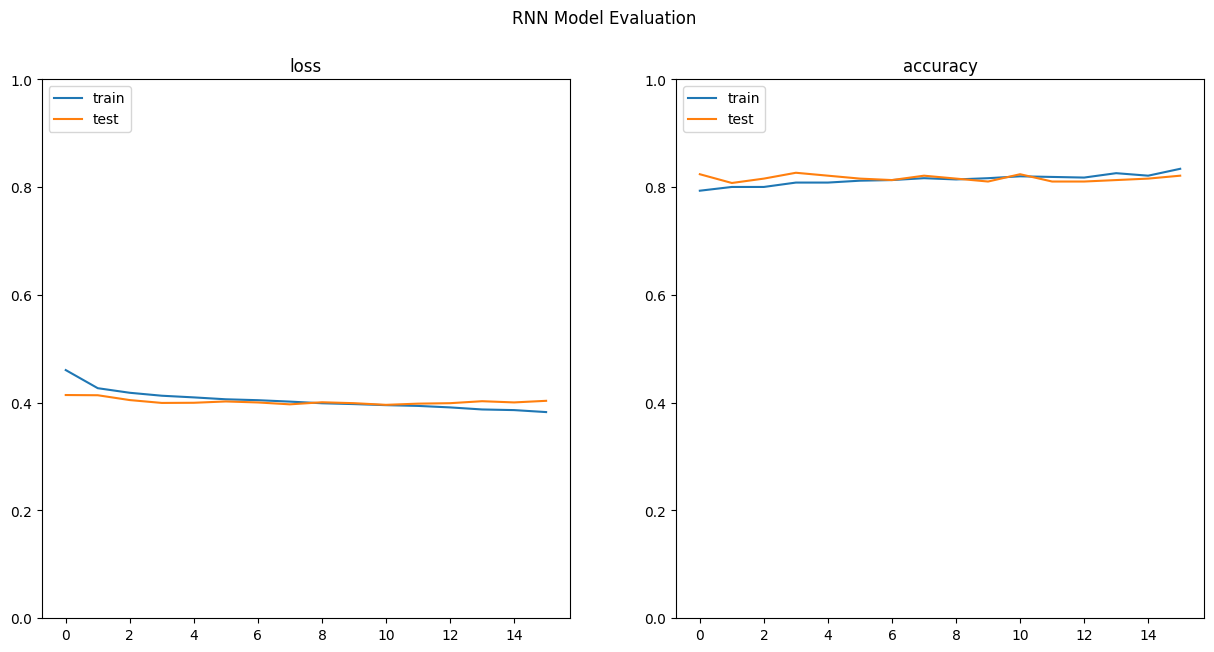

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
ax1.set_ylim(0, 1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('accuracy')
ax2.set_ylim(0, 1)
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

In [23]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function
y_pred = (y_pred > 0.5) # let's turn these into predictions (0 or 1)

print(classification_report(y_test, y_pred, digits=4))

12/12 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0     0.8176    0.7784    0.7975       167
           1     0.8238    0.8564    0.8398       202

    accuracy                         0.8211       369
   macro avg     0.8207    0.8174    0.8187       369
weighted avg     0.8210    0.8211    0.8207       369



In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['RNN'], 
        'time': [end_time - start_time],
        'accuracy': [accuracy_score(y_test, y_pred)], 
        'precision': [precision_score(y_test, y_pred)], 
        'recall': [recall_score(y_test, y_pred)], 
        'f1': [f1_score(y_test, y_pred)]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

# Deep RNN

**Be careful: when stacking RNN layers, you have to set "return_sequences" to True. This enables the layer to send a "sequence" of values to the next layer -- jut like how it uses a sequence of values for training.**

**Since the last layer is DENSE, it can't take sequence data. Therefore, you CANNOT return sequences from the previous layer. So, remove** `return_sequences` **from previous layer.**

In [25]:
n_steps = 36
n_inputs = 1

model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[n_steps, n_inputs]),
        keras.layers.SimpleRNN(16, return_sequences=True),
        keras.layers.SimpleRNN(32, return_sequences=False), 
        keras.layers.Dense(1, activation='sigmoid')
    ]
)

In [26]:
model.compile(
    loss="binary_crossentropy", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 36, 32)            1088      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 36, 16)            784       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                1568      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,473
Trainable params: 3,473
Non-trainable params: 0
_________________________________________________________________


### How to  intepret the output shape?

* First layer:
  * None is a wild-card representing the number of observations - this will be the number of observations in a batch that is fed into the network.
  * There are 36 features (which are the 'time steps' of values in the sequence), and there are 32 RNN units.
    * (batch size, time steps, features) = (None, 36, 32)
* etc. (see previous models where I elaborate on the output shape - writing this is getting repetitive)

### Calculate the number of paramaters for the model

In [27]:
p = 1 # number of parameters per unit (for RNN one remember gate)
b = 1 # number of biases per unit, for RNN this is 1 (for GRU this is 3, and LSTM this is 4)

##################################
# For first layer....

h = 32 # number of units in the layer
i = 1  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# For second layer....

h = 16 # number of units in the layer
i = 32  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("Second layer params = ", params)

##################################
# For third layer....

h = 32 # number of units in the layer
i = 16  # number of inputs (previous layer has 16 inutes, so we have 16 inputs)

params = p*(h**2+i*h+b*h)
print("Third layer params = ", params)


##################################
# for the last layer

# This is simply 32 outputs coming from the previous later plus 1 bias term
print("Last layer params = ", 32+1)

First layer params =  1088
Second layer params =  784
Third layer params =  1568
Last layer params =  33


In [28]:
from tensorflow.keras.callbacks import EarlyStopping

# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=['accuracy']
)

In [29]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=5, verbose=1, mode='auto')

history = model.fit(
    X_train, 
    y_train, 
    epochs=20,
    validation_data = (X_test, y_test), 
    callbacks=[early_stop]
)  

end_time = time.time()

Epoch 1/20
27/27 [==============================] - 8s 62ms/step - loss: 0.4654 - accuracy: 0.7921 - val_loss: 0.4037 - val_accuracy: 0.8184
Epoch 2/20
27/27 [==============================] - 1s 28ms/step - loss: 0.4198 - accuracy: 0.8002 - val_loss: 0.4287 - val_accuracy: 0.8049
Epoch 3/20
27/27 [==============================] - 1s 27ms/step - loss: 0.4085 - accuracy: 0.8095 - val_loss: 0.4060 - val_accuracy: 0.8130
Epoch 4/20
27/27 [==============================] - 1s 28ms/step - loss: 0.4028 - accuracy: 0.8118 - val_loss: 0.3947 - val_accuracy: 0.8130
Epoch 5/20
27/27 [==============================] - 1s 29ms/step - loss: 0.3973 - accuracy: 0.8188 - val_loss: 0.4016 - val_accuracy: 0.7995
Epoch 6/20
27/27 [==============================] - 1s 28ms/step - loss: 0.3917 - accuracy: 0.8258 - val_loss: 0.4182 - val_accuracy: 0.7967
Epoch 7/20
27/27 [==============================] - 1s 27ms/step - loss: 0.3870 - accuracy: 0.8304 - val_loss: 0.4109 - val_accuracy: 0.8076
Epoch 8/20
27

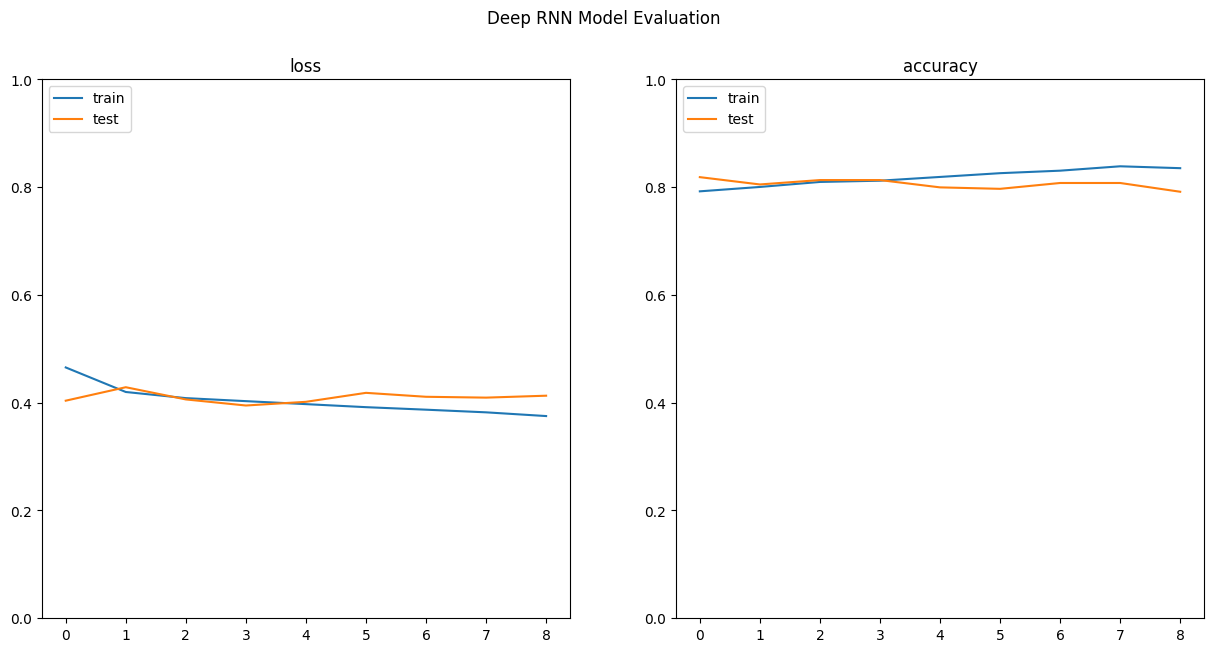

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Deep RNN Model Evaluation')

ax1.set_title('loss')
ax1.set_ylim(0, 1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('accuracy')
ax2.set_ylim(0, 1)
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

In [31]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function
y_pred = (y_pred > 0.5) # let's turn these into predictions (0 or 1)

print(classification_report(y_test, y_pred, digits=4))

12/12 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0     0.7812    0.7485    0.7645       167
           1     0.7990    0.8267    0.8127       202

    accuracy                         0.7913       369
   macro avg     0.7901    0.7876    0.7886       369
weighted avg     0.7910    0.7913    0.7909       369



In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['Deep RNN'], 
        'time': [end_time - start_time],
        'accuracy': [accuracy_score(y_test, y_pred)], 
        'precision': [precision_score(y_test, y_pred)], 
        'recall': [recall_score(y_test, y_pred)], 
        'f1': [f1_score(y_test, y_pred)]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

# LSTM with one layer

In [33]:
n_steps = 36
n_inputs = 1

model = keras.models.Sequential(
    [
        keras.layers.LSTM(32, input_shape=[n_steps, n_inputs]),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)

In [34]:
model.compile(
    loss="binary_crossentropy", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=['accuracy']
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


### Calculate the number of paramaters for the model

In [35]:
p = 4 # number of parameters per unit (for LSTM: 1 forget gate, 2 input gates, and 1 output gate)
b = 1 # number of biases per unit, for LSTM this is 1

##################################
# For first layer....

h = 32 # number of units in the layer
i = 1  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# for the last layer

# This is simply 32 outputs coming from the previous later plus 1 bias term
print("Last layer params = ", 32+1)

First layer params =  4352
Last layer params =  33


In [36]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0, patience=5, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
) 

end_time = time.time()

Epoch 1/20
27/27 [==============================] - 7s 63ms/step - loss: 0.5648 - accuracy: 0.7851 - val_loss: 0.4828 - val_accuracy: 0.8293
Epoch 2/20
27/27 [==============================] - 1s 24ms/step - loss: 0.4863 - accuracy: 0.7944 - val_loss: 0.4355 - val_accuracy: 0.8320
Epoch 3/20
27/27 [==============================] - 1s 23ms/step - loss: 0.4566 - accuracy: 0.7851 - val_loss: 0.4187 - val_accuracy: 0.8320
Epoch 4/20
27/27 [==============================] - 1s 23ms/step - loss: 0.4436 - accuracy: 0.7875 - val_loss: 0.4109 - val_accuracy: 0.8266
Epoch 5/20
27/27 [==============================] - 1s 23ms/step - loss: 0.4356 - accuracy: 0.7898 - val_loss: 0.4074 - val_accuracy: 0.8238
Epoch 6/20
27/27 [==============================] - 1s 27ms/step - loss: 0.4289 - accuracy: 0.7909 - val_loss: 0.4054 - val_accuracy: 0.8266
Epoch 7/20
27/27 [==============================] - 1s 23ms/step - loss: 0.4251 - accuracy: 0.7921 - val_loss: 0.4042 - val_accuracy: 0.8238
Epoch 8/20
27

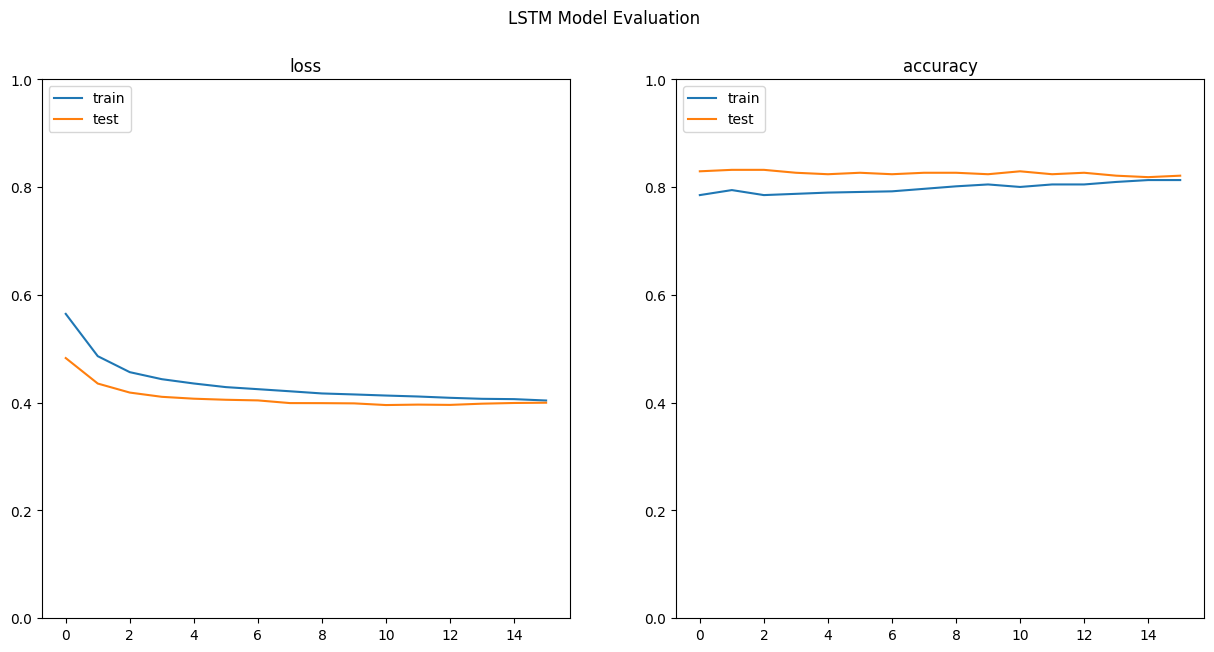

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('LSTM Model Evaluation')

ax1.set_title('loss')
ax1.set_ylim(0, 1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('accuracy')
ax2.set_ylim(0, 1)
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

In [38]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function
y_pred = (y_pred > 0.5) # let's turn these into predictions (0 or 1)

print(classification_report(y_test, y_pred, digits=4))

12/12 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

           0     0.8217    0.7725    0.7963       167
           1     0.8208    0.8614    0.8406       202

    accuracy                         0.8211       369
   macro avg     0.8212    0.8169    0.8184       369
weighted avg     0.8212    0.8211    0.8205       369



In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['LSTM'], 
        'time': [end_time - start_time],
        'accuracy': [accuracy_score(y_test, y_pred)], 
        'precision': [precision_score(y_test, y_pred)], 
        'recall': [recall_score(y_test, y_pred)], 
        'f1': [f1_score(y_test, y_pred)]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

# LSTM with more layers

In [40]:
n_steps = 36
n_inputs = 1

model = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True, input_shape=[n_steps, n_inputs]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1, activation='sigmoid')
])

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(
    loss="binary_crossentropy", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 36, 32)            4352      
                                                                 
 lstm_2 (LSTM)               (None, 36, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


### Calculate the number of paramaters for the model

In [42]:
# Everything is the same as calculating the RNN, except for p
p = 4 # number of parameters per unit (for LSTM - 1 forget gate, 2 input gates, and 1 output gate)
b = 1 # number of biases per unit, for LSTM this is 1

##################################
# For first layer....

h = 32 # number of units in the layer
i = 1  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# for the second layer

h = 32 # number of units in the layer
i = 32  # number of inputs (previous layer has 32 units, therefore 32 incoming inputs)

params = p*(h**2+i*h+b*h)
print("Second layer params = ", params)

##################################
# for the third layer

h = 32 # number of units in the layer
i = 32  # number of inputs (previous layer has 32 units, therefore 32 incoming inputs)

params = p*(h**2+i*h+b*h)
print("Third layer params = ", params)


##################################
# for the last layer

# This is simply 32 outputs coming from the previous later plus 1 bias term
print("Last layer params = ", 32+1)

First layer params =  4352
Second layer params =  8320
Third layer params =  8320
Last layer params =  33


In [43]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0, patience=5, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=20,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop] # we defined this early_stop callback function earlier
)

end_time = time.time()

Epoch 1/20
27/27 [==============================] - 25s 249ms/step - loss: 0.5551 - accuracy: 0.7456 - val_loss: 0.4832 - val_accuracy: 0.7615
Epoch 2/20
27/27 [==============================] - 3s 110ms/step - loss: 0.4973 - accuracy: 0.7584 - val_loss: 0.4558 - val_accuracy: 0.7751
Epoch 3/20
27/27 [==============================] - 3s 108ms/step - loss: 0.4747 - accuracy: 0.7654 - val_loss: 0.4325 - val_accuracy: 0.8157
Epoch 4/20
27/27 [==============================] - 3s 112ms/step - loss: 0.4625 - accuracy: 0.7700 - val_loss: 0.4265 - val_accuracy: 0.8211
Epoch 5/20
27/27 [==============================] - 3s 112ms/step - loss: 0.4564 - accuracy: 0.7793 - val_loss: 0.4268 - val_accuracy: 0.8293
Epoch 6/20
27/27 [==============================] - 3s 112ms/step - loss: 0.4469 - accuracy: 0.7770 - val_loss: 0.4259 - val_accuracy: 0.8320
Epoch 7/20
27/27 [==============================] - 3s 122ms/step - loss: 0.4401 - accuracy: 0.7886 - val_loss: 0.4194 - val_accuracy: 0.8293
Epoch

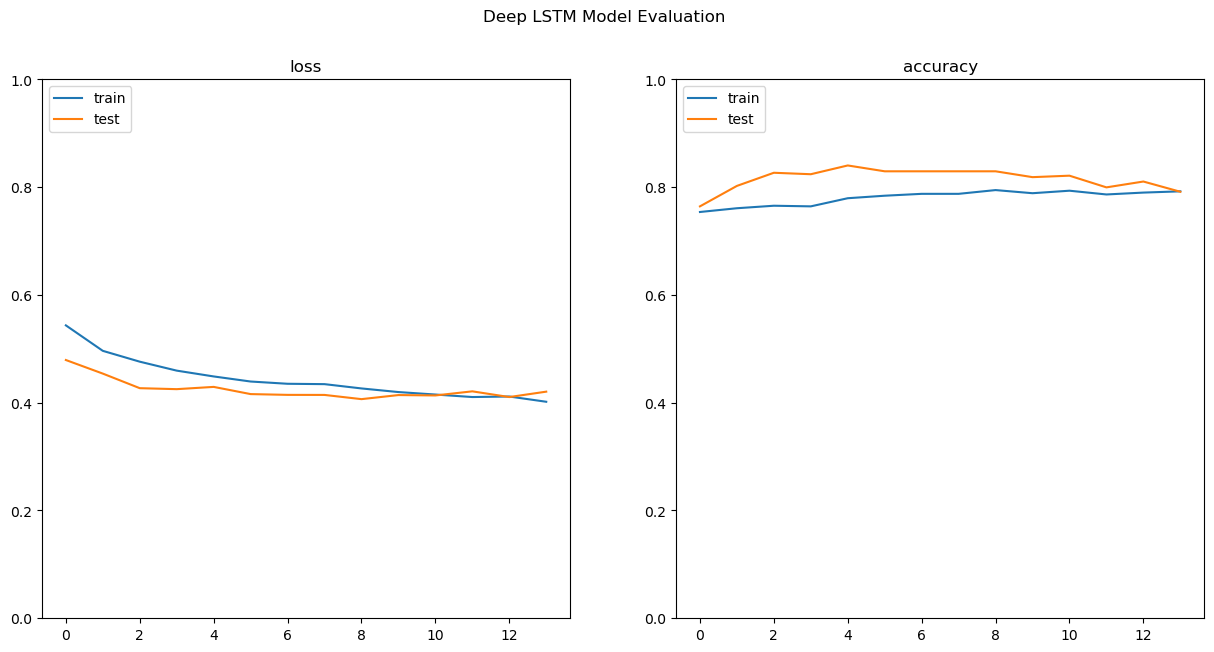

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Deep LSTM Model Evaluation')

ax1.set_title('loss')
ax1.set_ylim(0, 1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('accuracy')
ax2.set_ylim(0, 1)
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

In [44]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function
y_pred = (y_pred > 0.5) # let's turn these into predictions (0 or 1)

print(classification_report(y_test, y_pred, digits=4))

12/12 [==============================] - 4s 32ms/step
              precision    recall  f1-score   support

           0     0.8239    0.7006    0.7573       167
           1     0.7797    0.8762    0.8252       202

    accuracy                         0.7967       369
   macro avg     0.8018    0.7884    0.7912       369
weighted avg     0.7997    0.7967    0.7944       369



In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['Deep LSTM'], 
        'time': [end_time - start_time],
        'accuracy': [accuracy_score(y_test, y_pred)], 
        'precision': [precision_score(y_test, y_pred)], 
        'recall': [recall_score(y_test, y_pred)], 
        'f1': [f1_score(y_test, y_pred)]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

# GRU with one layer

In [46]:
n_steps = 36
n_inputs = 1

model = keras.models.Sequential([
    keras.layers.GRU(32, input_shape=[n_steps, n_inputs]),
    keras.layers.Dense(1, activation='sigmoid')
])

In [47]:
model.compile(
    loss="binary_crossentropy", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=['accuracy']
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3360      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


### Calculate the number of paramaters for the model

In [48]:
# Everything is the same as calculating the RNN or LSTM parameters, except for p
p = 3 # number of parameters per unit (for GRU - 1 forget gate, 1 input gates, and 1 output gate)
b = 2 # number of biases per unit, for GRU this is 2

##################################
# For first layer....

h = 32 # number of units in the layer
i = 1  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# for the last layer

# This is simply 32 outputs coming from the previous later plus 1 bias term
print("Last layer params = ", 32+1)

First layer params =  3360
Last layer params =  33


In [49]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0, patience=5, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stop] # we defined this early_stop callback function earlier
)

end_time = time.time()

Epoch 1/20
27/27 [==============================] - 10s 94ms/step - loss: 0.6856 - accuracy: 0.5389 - val_loss: 0.5257 - val_accuracy: 0.8238
Epoch 2/20
27/27 [==============================] - 1s 38ms/step - loss: 0.4990 - accuracy: 0.7886 - val_loss: 0.4326 - val_accuracy: 0.8266
Epoch 3/20
27/27 [==============================] - 1s 38ms/step - loss: 0.4531 - accuracy: 0.7967 - val_loss: 0.4112 - val_accuracy: 0.8266
Epoch 4/20
27/27 [==============================] - 1s 37ms/step - loss: 0.4364 - accuracy: 0.8026 - val_loss: 0.4031 - val_accuracy: 0.8266
Epoch 5/20
27/27 [==============================] - 1s 37ms/step - loss: 0.4270 - accuracy: 0.8049 - val_loss: 0.4009 - val_accuracy: 0.8184
Epoch 6/20
27/27 [==============================] - 1s 38ms/step - loss: 0.4211 - accuracy: 0.7967 - val_loss: 0.3985 - val_accuracy: 0.8184
Epoch 7/20
27/27 [==============================] - 1s 38ms/step - loss: 0.4167 - accuracy: 0.7933 - val_loss: 0.3970 - val_accuracy: 0.8184
Epoch 8/20
2

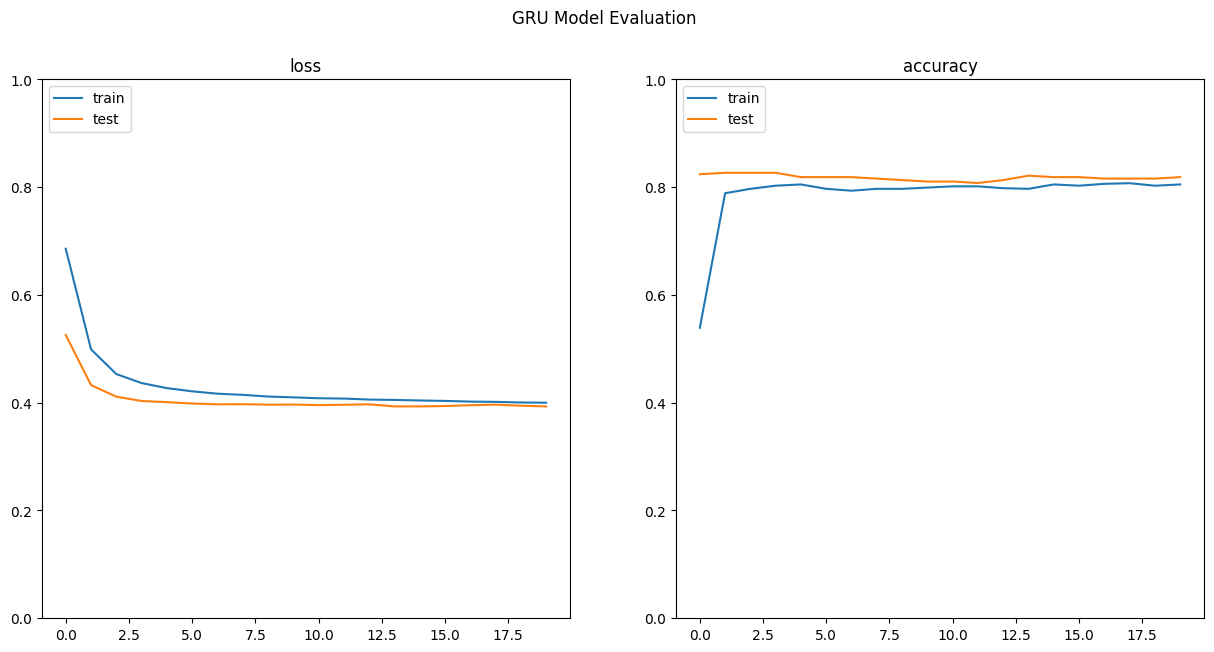

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('GRU Model Evaluation')

ax1.set_title('loss')
ax1.set_ylim(0, 1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('accuracy')
ax2.set_ylim(0, 1)
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

In [51]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function
y_pred = (y_pred > 0.5) # let's turn these into predictions (0 or 1)

print(classification_report(y_test, y_pred, digits=4))

12/12 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0     0.8247    0.7605    0.7913       167
           1     0.8140    0.8663    0.8393       202

    accuracy                         0.8184       369
   macro avg     0.8193    0.8134    0.8153       369
weighted avg     0.8188    0.8184    0.8176       369



In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['GRU'], 
        'time': [end_time - start_time],
        'accuracy': [accuracy_score(y_test, y_pred)], 
        'precision': [precision_score(y_test, y_pred)], 
        'recall': [recall_score(y_test, y_pred)], 
        'f1': [f1_score(y_test, y_pred)]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

# GRU with more layers

In [53]:
n_steps = 36
n_inputs = 1

model = keras.models.Sequential([
    keras.layers.GRU(32, return_sequences=True, input_shape=[n_steps, n_inputs]),
    keras.layers.GRU(32, return_sequences=True),
    keras.layers.GRU(32),
    keras.layers.Dense(1, activation='sigmoid')
])

In [54]:
model.compile(
    loss="binary_crossentropy", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=['accuracy']
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 36, 32)            3360      
                                                                 
 gru_2 (GRU)                 (None, 36, 32)            6336      
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


### Calculate the number of paramaters for the model

In [55]:
# Everything is the same as calculating the RNN or LSTM parameters, except for p
p = 3 # number of parameters per unit (for GRU - 1 forget gate, 1 input gates, and 1 output gate)
b = 2 # number of biases per unit, for GRU this is 2

##################################
# For first layer....

h = 32 # number of units in the layer
i = 1  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# For second layer....

h = 32 # number of units in the layer
i = 32  # number of inputs (previous layer has 32 units, therefore 32 inputs)

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# For third layer....

h = 32 # number of units in the layer
i = 32  # number of inputs (previous layer has 32 units, therefore 32 inputs)

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)


##################################
# for the last layer

# This is simply 32 outputs coming from the previous later plus 1 bias term
print("Last layer params = ", 32+1)

First layer params =  3360
First layer params =  6336
First layer params =  6336
Last layer params =  33


In [56]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0, patience=5, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=20,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop] 
)

end_time = time.time()

Epoch 1/20
27/27 [==============================] - 25s 248ms/step - loss: 0.5144 - accuracy: 0.7584 - val_loss: 0.4245 - val_accuracy: 0.8266
Epoch 2/20
27/27 [==============================] - 3s 106ms/step - loss: 0.4580 - accuracy: 0.7793 - val_loss: 0.4130 - val_accuracy: 0.8374
Epoch 3/20
27/27 [==============================] - 3s 105ms/step - loss: 0.4408 - accuracy: 0.7816 - val_loss: 0.4005 - val_accuracy: 0.8347
Epoch 4/20
27/27 [==============================] - 3s 106ms/step - loss: 0.4301 - accuracy: 0.7851 - val_loss: 0.3984 - val_accuracy: 0.8238
Epoch 5/20
27/27 [==============================] - 3s 107ms/step - loss: 0.4229 - accuracy: 0.7933 - val_loss: 0.4035 - val_accuracy: 0.8157
Epoch 6/20
27/27 [==============================] - 3s 106ms/step - loss: 0.4173 - accuracy: 0.7956 - val_loss: 0.4054 - val_accuracy: 0.8103
Epoch 7/20
27/27 [==============================] - 3s 108ms/step - loss: 0.4123 - accuracy: 0.7967 - val_loss: 0.3974 - val_accuracy: 0.8130
Epoch

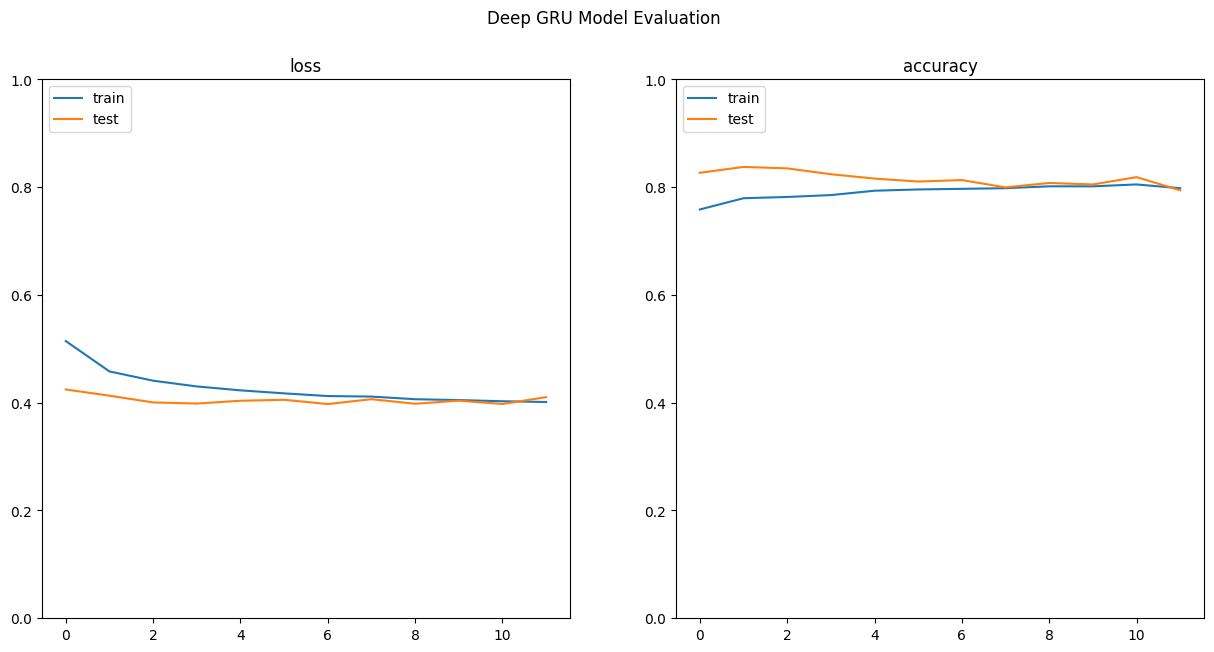

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Deep GRU Model Evaluation')

ax1.set_title('loss')
ax1.set_ylim(0, 1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('accuracy')
ax2.set_ylim(0, 1)
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

In [58]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function
y_pred = (y_pred > 0.5) # let's turn these into predictions (0 or 1)

print(classification_report(y_test, y_pred, digits=4))

12/12 [==============================] - 4s 40ms/step
              precision    recall  f1-score   support

           0     0.7935    0.7365    0.7640       167
           1     0.7944    0.8416    0.8173       202

    accuracy                         0.7940       369
   macro avg     0.7940    0.7891    0.7906       369
weighted avg     0.7940    0.7940    0.7932       369



In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['Deep GRU'], 
        'time': [end_time - start_time],
        'accuracy': [accuracy_score(y_test, y_pred)], 
        'precision': [precision_score(y_test, y_pred)], 
        'recall': [recall_score(y_test, y_pred)], 
        'f1': [f1_score(y_test, y_pred)]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

# Conv1D

In [60]:
n_steps = 36
n_inputs = 1

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=10, kernel_size=3, strides=1, padding="valid", input_shape=[n_steps, n_inputs]),
    keras.layers.Conv1D(filters=20, kernel_size=3, strides=1, padding="valid"),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 34, 10)            40        
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 20)            620       
                                                                 
 lstm_4 (LSTM)               (None, 32, 32)            6784      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 15,797
Trainable params: 15,797
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.compile(
    loss="binary_crossentropy", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.010), 
    metrics=['accuracy']
)

In [62]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0, patience=5, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=20,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop] 
)

end_time = time.time()

Epoch 1/20
27/27 [==============================] - 22s 314ms/step - loss: 0.5050 - accuracy: 0.7561 - val_loss: 0.4129 - val_accuracy: 0.8238
Epoch 2/20
27/27 [==============================] - 6s 210ms/step - loss: 0.4524 - accuracy: 0.7700 - val_loss: 0.4162 - val_accuracy: 0.8076
Epoch 3/20
27/27 [==============================] - 6s 212ms/step - loss: 0.4259 - accuracy: 0.8026 - val_loss: 0.4183 - val_accuracy: 0.8076
Epoch 4/20
27/27 [==============================] - 6s 208ms/step - loss: 0.4199 - accuracy: 0.8014 - val_loss: 0.4102 - val_accuracy: 0.8238
Epoch 5/20
27/27 [==============================] - 6s 208ms/step - loss: 0.4152 - accuracy: 0.8072 - val_loss: 0.4098 - val_accuracy: 0.8184
Epoch 6/20
27/27 [==============================] - 6s 212ms/step - loss: 0.4107 - accuracy: 0.7991 - val_loss: 0.4205 - val_accuracy: 0.8293
Epoch 7/20
27/27 [==============================] - 6s 213ms/step - loss: 0.4041 - accuracy: 0.8072 - val_loss: 0.4116 - val_accuracy: 0.8293
Epoch

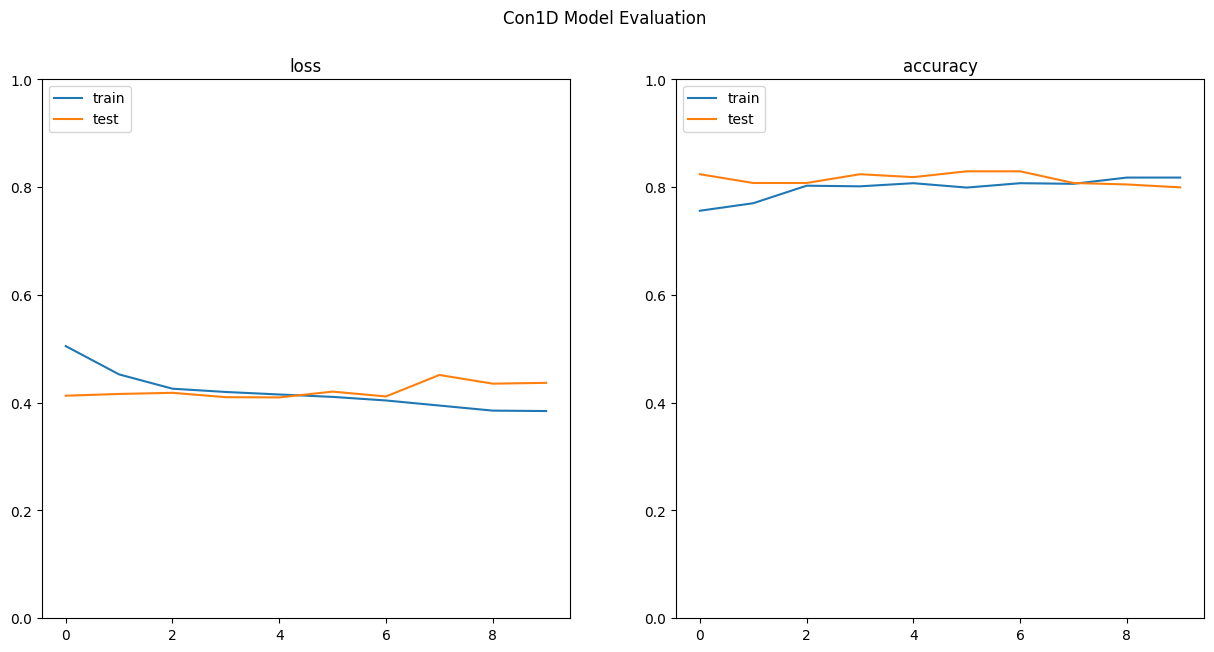

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Con1D Model Evaluation')

ax1.set_title('loss')
ax1.set_ylim(0, 1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('accuracy')
ax2.set_ylim(0, 1)
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

In [64]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function
y_pred = (y_pred > 0.5) # let's turn these into predictions (0 or 1)

print(classification_report(y_test, y_pred, digits=4))

12/12 [==============================] - 3s 23ms/step
              precision    recall  f1-score   support

           0     0.8163    0.7186    0.7643       167
           1     0.7883    0.8663    0.8255       202

    accuracy                         0.7995       369
   macro avg     0.8023    0.7924    0.7949       369
weighted avg     0.8010    0.7995    0.7978       369



In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['Conv1D Deep LSTM'], 
        'time': [end_time - start_time],
        'accuracy': [accuracy_score(y_test, y_pred)], 
        'precision': [precision_score(y_test, y_pred)], 
        'recall': [recall_score(y_test, y_pred)], 
        'f1': [f1_score(y_test, y_pred)]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

## Summary of results

In [66]:
df_results.sort_values(by=['accuracy', 'precision', 'recall', 'f1'], ascending=False)

,model,time,accuracy,precision,recall,f1
1,RNN,8.275707,0.821138,0.823810,0.856436,0.839806
3,LSTM,16.717640,0.821138,0.820755,0.861386,0.840580
5,GRU,29.735120,0.818428,0.813953,0.866337,0.839329
7,Conv1D Deep LSTM,73.593200,0.799458,0.788288,0.866337,0.825472
0,NN,4.180996,0.796748,0.792627,0.851485,0.821002
4,Deep LSTM,82.395439,0.796748,0.779736,0.876238,0.825175
6,Deep GRU,56.917886,0.794038,0.794393,0.841584,0.817308
2,Deep RNN,13.777741,0.791328,0.799043,0.826733,0.812652
